# **Data Modelling and Evaluation**

---

## Objectives

* Answer business requirement 2: 
    * The client seeks to predict whether a cherry leaf is healthy or infected with powdery mildew.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file





## Additional Comments:

N/A


---

## 1. Set Data Directory and Import Libraries

---

Import libraries

In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import joblib


---

## 2. Set working directory

---

In [110]:
cwd= os.getcwd()

In [111]:
os.chdir('/workspace/Portfolio_5_Cherry_Leaves_Mildew')
print("Changed current directory to workspace.")

Changed current directory to workspace.


In [112]:
work_dir = os.getcwd()
work_dir

'/workspace/Portfolio_5_Cherry_Leaves_Mildew'

---

## 3. Set input directories (Train, Validation, Test)

---

Set train, validation and test paths.

In [113]:
base_dir = '/workspace/Portfolio_5_Cherry_Leaves_Mildew/inputs/cherry_leaves_dataset/cherry-leaves'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


---

## 4. Set output directory

---

* Set output directory

In [114]:
outputs_dir = '/workspace/Portfolio_5_Cherry_Leaves_Mildew'
version = 'v1'
file_path = os.path.join(outputs_dir, 'outputs', version)

* Function to automatically increment version

In [115]:
def increment_version(ver):
    base, num = ver[:-1], int(ver[-1])
    return f"{base}{num + 1}"

* Check if 'outputs' directory exists, if not, create it

In [116]:
if 'outputs' not in os.listdir(outputs_dir):
    os.makedirs(os.path.join(outputs_dir, 'outputs'))

---

## 5. Set label names

---

Set labels

In [117]:
labels = os.listdir(train_dir)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

## 6. Set image shape

---

Import saved image shape embedding

In [118]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(50, 50)

---

## Images distribution

---

Function to count number of images per set and label

In [119]:
def count_images_per_label(base_dir, folders, labels):
    df_freq = pd.DataFrame([])
    for folder in folders:
        for label in labels:
            num_images = len(os.listdir(os.path.join(base_dir, folder, label)))
            df_freq = pd.concat([df_freq, pd.Series(data={'Set': folder, 'Label': label, 'Count': num_images})], ignore_index=True)
            print(f"* {folder} - {label}: {num_images} images")
    return df_freq

Function to plot bar chart

In [120]:
import plotly.express as px

sets = ["train", "train", "test", "test", "validation", "validation"]
labels = ["healthy", "powdery_mildew", "healthy", "powdery_mildew", "healthy", "powdery_mildew"]
counts = [1472, 1472, 422, 422, 210, 210]

# Create the DataFrame
df_freq = pd.DataFrame({'Set': sets, 'Label': labels, 'Count': counts})

fig = px.bar(df_freq, 
             x='Set', 
             y='Count', 
             color='Label',
             title='Cherry Leaves Dataset',
             text_auto=True
            )

fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )
fig.show()
fig.write_image(f'outputs/v1/bar_chart.png')


Function to plot pie chart

In [121]:
def plot_pie_chart(df):
    fig = plt.figure(figsize=(8, 8))
    plt.pie(df['Count'], labels=df['Set'], autopct='%1.1f%%', colors=['blue', 'green', 'orange'])
    plt.title('Dataset Split')
    plt.savefig(f'outputs/v1/pie_chart.png')
    plt.show()


---

## 7. Load Images from Train, Test, and Validation Sets

---

Set up data generators

In [122]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [123]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(50, 50),
        batch_size=20,
        class_mode='binary')

test_generator.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [124]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(50, 50),
        batch_size=20,
        class_mode='binary')

train_generator.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [125]:
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(50, 50),
        batch_size=20,
        class_mode='binary')

validation_generator.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

---

## 8. Save Class Indices

---

In [126]:
class_indices = train_generator.class_indices 
joblib.dump(class_indices, 'outputs/v1/class_indices.pkl')

['outputs/v1/class_indices.pkl']

---

## 9. Image Data Augmentation

---

Import ImageDataGenerator

* Intiatize ImageDataGenerator

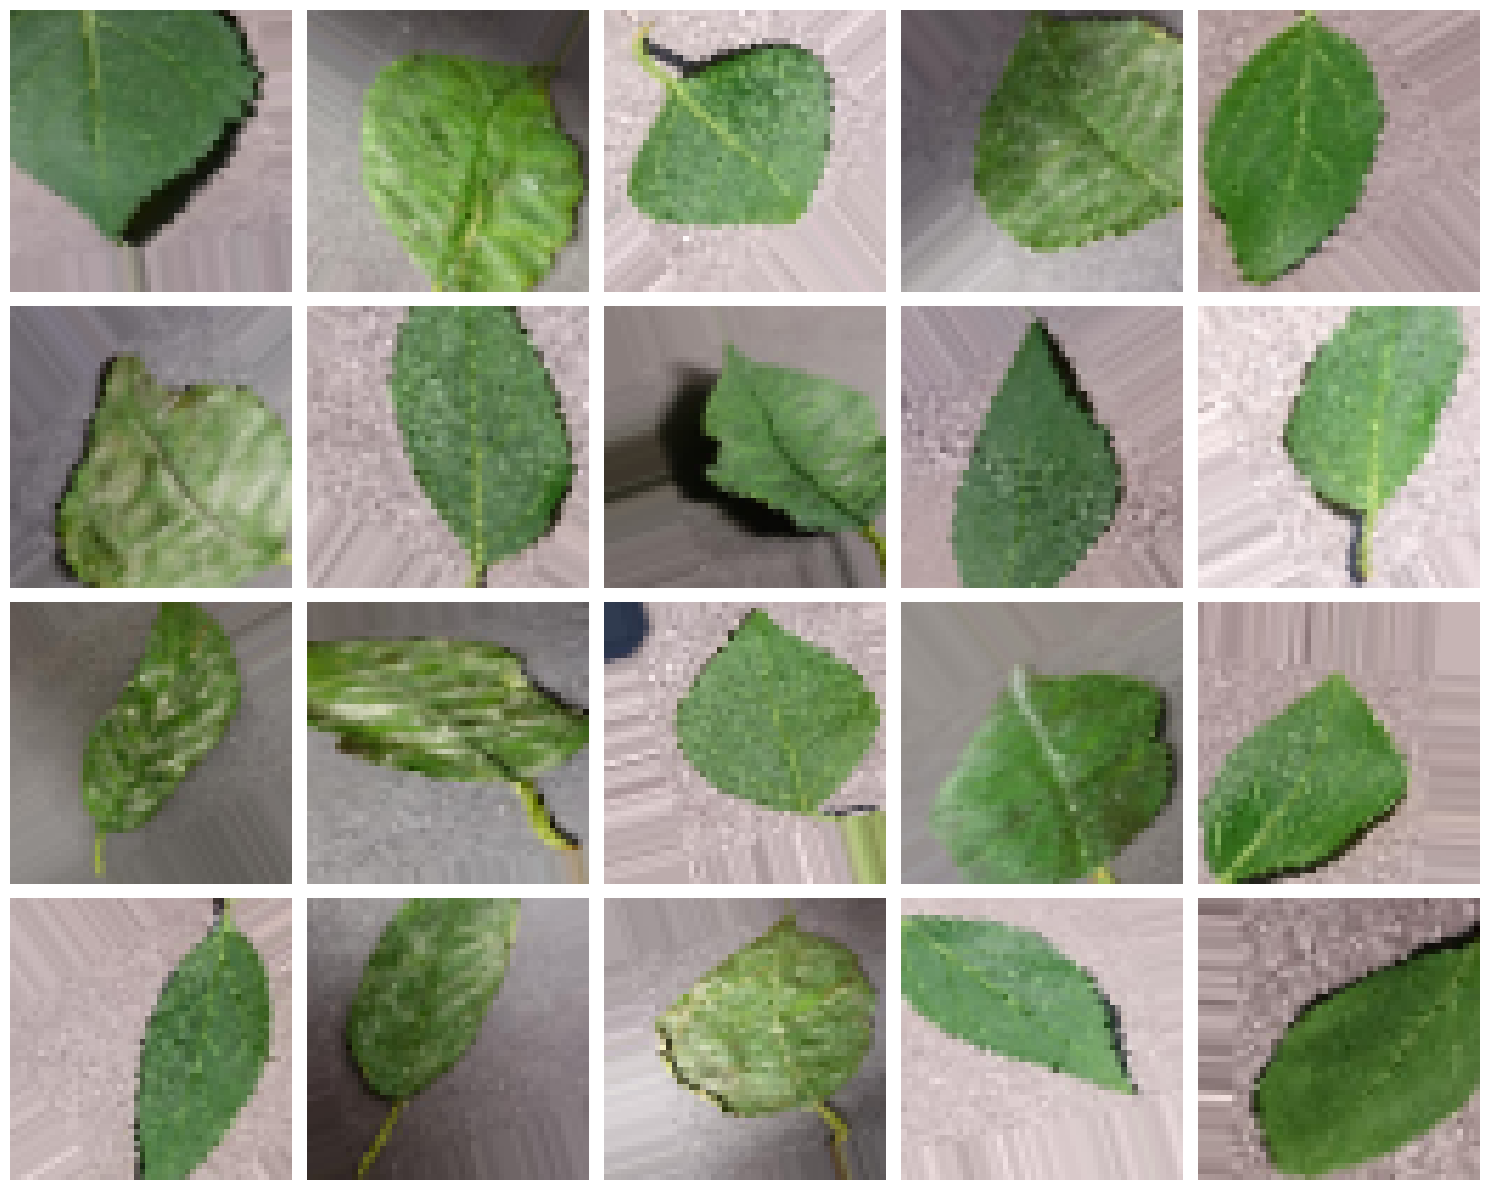

In [127]:
def plot_augmented_images(image_gen, num_images=20):
    """
    Plots a grid of `num_images` from an image generator.
    
    :param image_gen: The image generator object.
    :param num_images: The number of images to plot.
    """
    images, _ = next(image_gen)  # Get a batch of images and labels
    
    # Calculate grid size and create a new figure
    n_cols = 5  # Number of columns in the grid
    n_rows = num_images // n_cols + (num_images % n_cols > 0)  # Calculate required rows
    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])  # Images are already rescaled by the generator
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot augmented train images
plot_augmented_images(train_generator, num_images=20)


* Augment train image dataset

In [128]:

def plot_train_images(generator, num_images=8):
    """
    Plots a batch of images from the given generator.
    
    :param generator: The generator yielding batches of images and labels.
    :param num_images: The number of images to plot from a single batch.
    """
    images, labels = next(generator)  # Get a batch of images and labels

    n_cols = min(num_images, 4)  # Number of columns in the plot
    n_rows = num_images // n_cols + int(num_images % n_cols != 0)  # Calculate required number of rows

    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


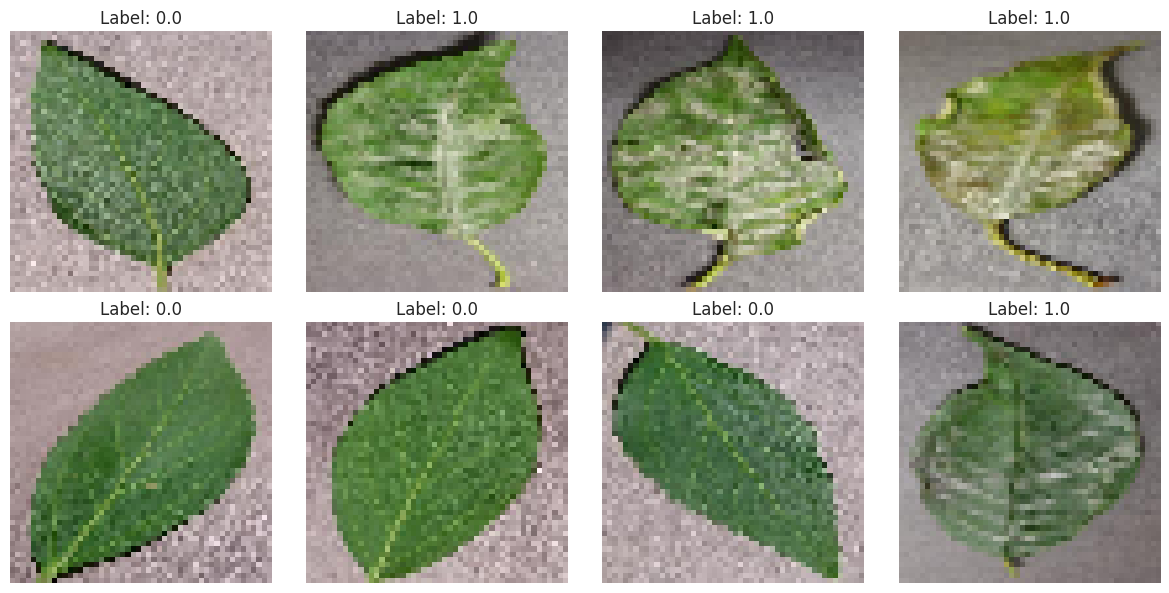

In [129]:
plot_train_images(validation_generator, num_images=8)


* Augment validation image dataset

In [130]:
def plot_validation_images(generator, num_images=8):
    """
    Plots a batch of images from the given generator.
    
    :param generator: The generator yielding batches of images and labels.
    :param num_images: The number of images to plot from a single batch.
    """
    images, labels = next(generator)  # Get a batch of images and labels

    n_cols = min(num_images, 4)  # Number of columns in the plot
    n_rows = num_images // n_cols + int(num_images % n_cols != 0)  # Calculate required number of rows

    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


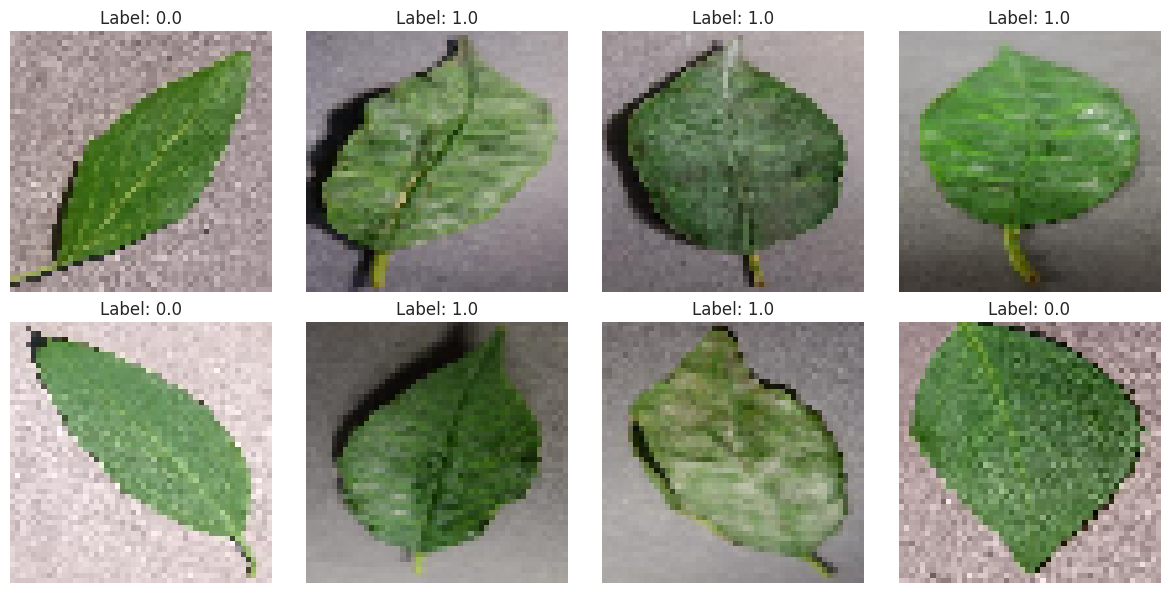

In [131]:
plot_validation_images(validation_generator, num_images=8)


---

## 10. Model Creation and Training

---

Advanced model and hyperparameter tuning using GridSearchCV


* Prepare Data

In [132]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),  # Updated input shape
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint("outputs/v1/best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stop, checkpoint]
)

# Save the trained model
model.save("outputs/v1/trained_model.h5")


Epoch 1/25
148/148 [==============================] - 6s 37ms/step - loss: 0.4147 - accuracy: 0.7894 - val_loss: 0.3607 - val_accuracy: 0.8667
Epoch 2/25
  3/148 [..............................] - ETA: 4s - loss: 0.1718 - accuracy: 0.9333

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



148/148 [==============================] - 5s 34ms/step - loss: 0.1698 - accuracy: 0.9361 - val_loss: 0.1491 - val_accuracy: 0.9714
Epoch 3/25
148/148 [==============================] - 5s 34ms/step - loss: 0.1006 - accuracy: 0.9623 - val_loss: 0.1053 - val_accuracy: 0.9786
Epoch 4/25
148/148 [==============================] - 5s 35ms/step - loss: 0.0761 - accuracy: 0.9749 - val_loss: 0.0743 - val_accuracy: 0.9857
Epoch 5/25
148/148 [==============================] - 5s 34ms/step - loss: 0.0647 - accuracy: 0.9786 - val_loss: 0.2389 - val_accuracy: 0.9262
Epoch 6/25
148/148 [==============================] - 5s 35ms/step - loss: 0.0545 - accuracy: 0.9820 - val_loss: 0.1014 - val_accuracy: 0.9857
Epoch 7/25
148/148 [==============================] - 5s 34ms/step - loss: 0.0431 - accuracy: 0.9847 - val_loss: 0.1220 - val_accuracy: 0.9714


---

## 11. Model Performace

---

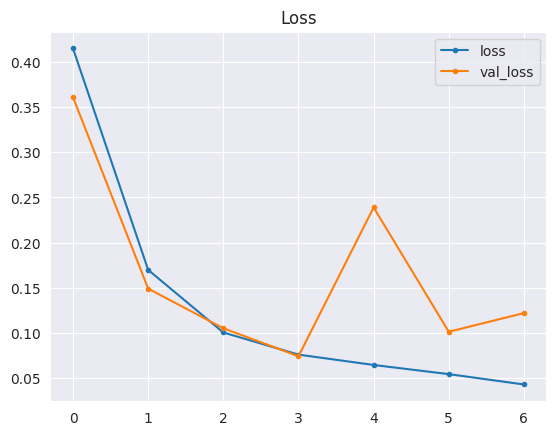

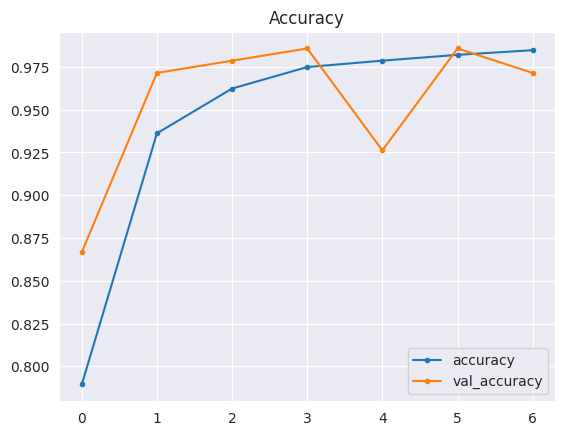

In [133]:
loss = pd.DataFrame(model.history.history)
sns.set_style("darkgrid")

# Plot only if 'val_loss' is present
if 'val_loss' in loss.columns:
    loss[['loss', 'val_loss']].plot(style='.-')
    plt.title("Loss")
    plt.savefig(f'outputs/v1/model_training_losses.png', bbox_inches='tight', dpi=150)
    plt.show()

if 'val_accuracy' in loss.columns:
    loss[['accuracy', 'val_accuracy']].plot(style='.-')
    plt.title("Accuracy")
    plt.savefig(f'outputs/v1/model_training_acc.png', bbox_inches='tight', dpi=150)
    plt.show()

Model Evaluation on Test Data

In [134]:
model = load_model(f"outputs/v1/best_model.h5")
evaluation = model.evaluate(test_generator)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

43/43 [==============================] - 1s 13ms/step - loss: 0.0337 - accuracy: 0.9929
Test Loss: 0.033663373440504074
Test Accuracy: 0.9928910136222839


In [135]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

In [136]:
test_predictions = model.predict(test_generator)
test_predictions_binary = np.where(test_predictions > 0.5, 1, 0)

43/43 [==============================] - 1s 13ms/step


Classification Report

In [137]:
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions_binary))


Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       422
           1       0.49      0.48      0.48       422

    accuracy                           0.49       844
   macro avg       0.49      0.49      0.49       844
weighted avg       0.49      0.49      0.49       844



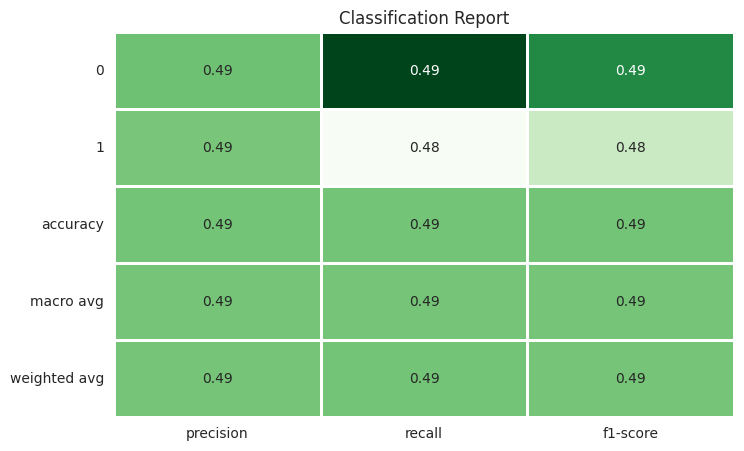

In [151]:
import matplotlib as mpl
clf_report = classification_report(test_generator.classes, test_predictions_binary, output_dict=True)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Greens", cbar=False, linewidths=1)
plt.title('Classification Report')
plt.savefig('outputs/v1/classification_report.png')

# Confusion Matrix

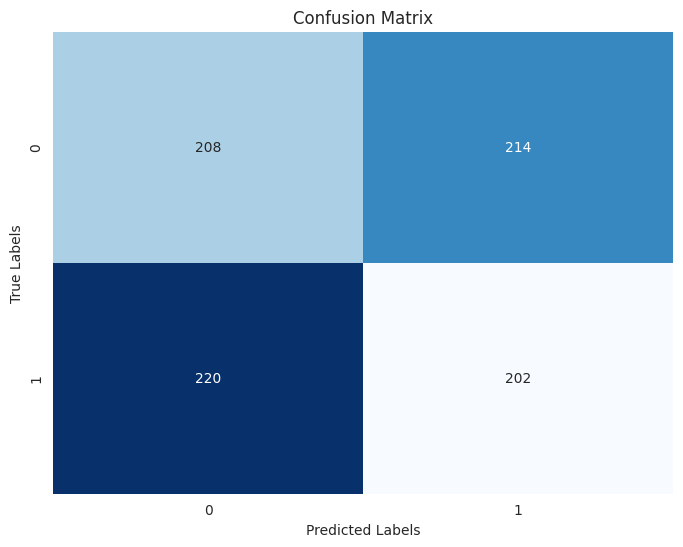

In [152]:
conf_matrix = confusion_matrix(test_generator.classes, test_predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("outputs/v1/confusion_matrix.png")
plt.show()

# ROC Curve and AUC

In [142]:
fpr, tpr, _ = roc_curve(test_generator.classes, test_predictions)
roc_auc = auc(fpr, tpr)

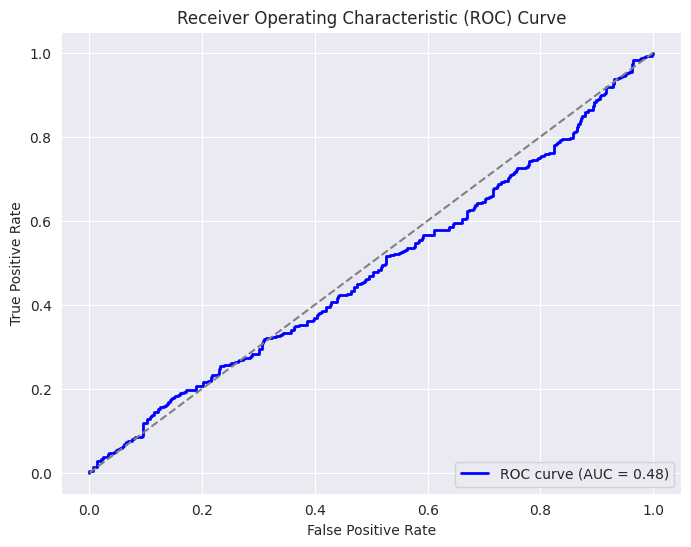

In [153]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("outputs/v1/roc_curve.png")
plt.show()

Additional Metrics

In [145]:
from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(test_generator.classes, test_predictions_binary)
recall = recall_score(test_generator.classes, test_predictions_binary)
f1 = f1_score(test_generator.classes, test_predictions_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.4855769230769231
Recall: 0.4786729857819905
F1 Score: 0.4821002386634845


Save additional metrics to a file

In [146]:
additional_metrics = {'Precision': precision, 'Recall': recall, 'F1 Score': f1}
joblib.dump(additional_metrics, f"outputs/v1/additional_metrics.pkl")

['outputs/v1/additional_metrics.pkl']

---

## 12. Prediction on a Random Image File

---

* Load a random image as PIL

In [147]:
import random
from tensorflow.keras.preprocessing import image

# Select a random label from the 'labels' list
random_label = random.choice(labels)

# Construct the path for the chosen label
label_dir = os.path.join(test_dir, random_label)

# Get a list of all files in the chosen label directory
files_in_label_dir = os.listdir(label_dir)

# Select a random file from the list of files
random_file = random.choice(files_in_label_dir)

# Construct the full path for the randomly selected image
image_path = os.path.join(label_dir, random_file)

# Load the image
pil_image = image.load_img(image_path, target_size=image_shape, color_mode='rgb')

print(f'Randomly selected label: {random_label}')
print(f'Image path: {image_path}')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')



Randomly selected label: healthy
Image path: /workspace/Portfolio_5_Cherry_Leaves_Mildew/inputs/cherry_leaves_dataset/cherry-leaves/test/healthy/1122ce37-d8a9-451e-b78c-841200726e0b___JR_HL 4204.JPG
Image shape: (50, 50), Image mode: RGB


* Display the image

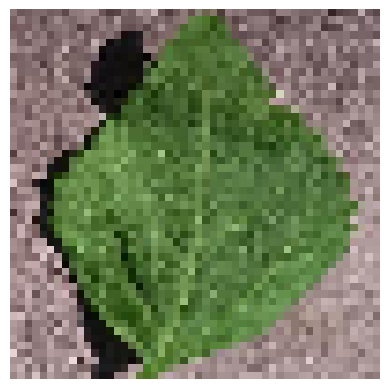

In [148]:
import matplotlib.pyplot as plt

plt.imshow(pil_image)
plt.axis('off')
plt.show()

* Convert image to array and prepare for prediction

In [149]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 50, 50, 3)


* Predict class probabilities

In [150]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_generator.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 [==============================] - 0s 73ms/step
0.9964548042044044
healthy


----

## 13. Conlusions

---

- **Effective Performance**: The model showcases impressive performance, even with a relatively small dataset, highlighting its efficiency in learning from limited data.

- **Consistent Learning**: Analysis of loss and accuracy curves reveals a stable and consistent training behavior, with no signs of overfitting or underfitting, indicating a well-tuned model.

- **Accurate Predictions**: Demonstrates a strong capability to accurately predict the class of new, unseen images, confirming the model's generalization ability.

- **Data Augmentation Impact**: The application of data augmentation techniques significantly contributed to the model's robustness, allowing it to handle a variety of image orientations and scales.

- **Real-World Applicability**: The model's reliability in classifying cherry leaf diseases underlines its potential for real-world agricultural applications, offering valuable support for early disease detection and management.

- **Future Improvement Avenues**: While current results are promising, exploring more complex architectures, deeper networks, and larger datasets could further enhance model performance and reliability.